In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
san = pd.read_csv('dane/san.csv', index_col=0, skiprows=2)
san.index = pd.to_datetime(san.index, format='%Y-%m-%d')

etf = pd.read_csv('dane/etfbw20tr.csv', index_col=0)
etf.index = pd.to_datetime(etf.index)

weights = np.array([2/3, 1/3])
portfolio = san.iloc[:,0] * weights[0] + etf.Zamkniecie * weights[1]
df = pd.concat([san.iloc[:,0], etf.Zamkniecie, portfolio], axis=1, join='outer').interpolate(method='linear', limit_direction='forward', axis=0).dropna()
df.columns = ['san', 'etf', 'portfolio']

<AxesSubplot:>

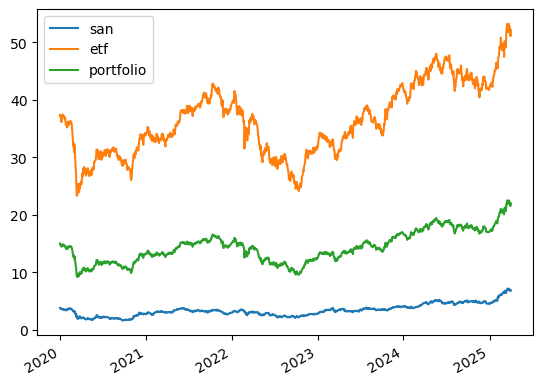

In [3]:
df.plot()

In [22]:
ret = pd.DataFrame({
'Annual returns': [
    (1 + df.san.pct_change().dropna()).prod() ** (252 / (df.shape[0]-1))-1,
    (1 + df.etf.pct_change().dropna()).prod() ** (252 / (df.shape[0]-1))-1]},
    index = df.columns[:-1])
san_ret = ret.loc['san'].values[0]
etf_ret = ret.loc['etf'].values[0]
ret.loc['portfolio'] = weights @ np.array([san_ret, etf_ret])
ret

,Annual returns
san,0.118074
etf,0.063853
portfolio,0.100000


In [5]:
cov_matrix = df[['san', 'etf']].pct_change().dropna().cov() * 252
san_var = cov_matrix.iloc[0, 0]
etf_var = cov_matrix.iloc[1, 1]
cov = cov_matrix.iloc[0, 1]
cov_matrix

,san,etf
san,0.154727,0.038790
etf,0.038790,0.055912


In [6]:
port_vol = np.sqrt(weights @ cov_matrix @ weights.T)
port_vol

0.3036778967567613

In [24]:
port_ret = ret.loc['portfolio'].values[0]
port_ret

0.10000035962805394

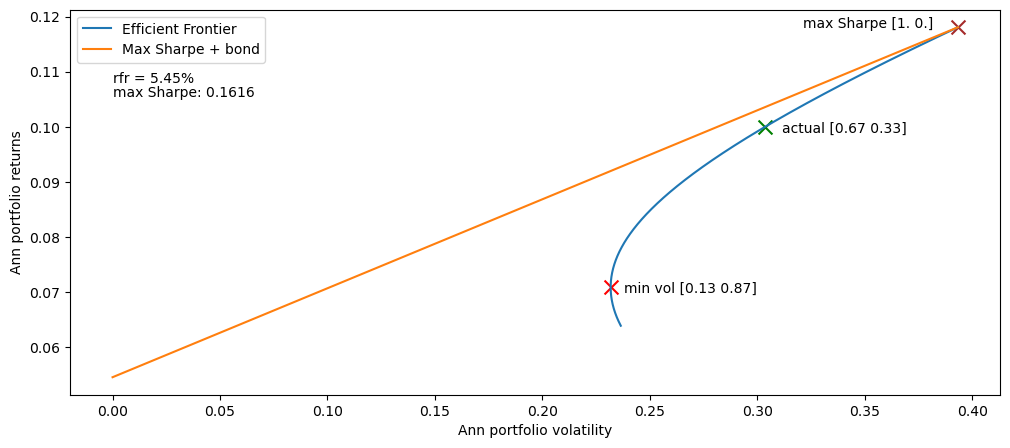

In [59]:
rfr = 0.0545
max_sharpe = 0
sharpe_indx = None
ws = np.stack((np.arange(0, 1.001, 0.001), 1-np.arange(0, 1.001, 0.001)), axis=1)
sigmas, returns = np.zeros(ws.shape[0]), np.zeros(ws.shape[0])
for i in range(ws.shape[0]):
    sigmas[i] = np.sqrt(ws[i] @ cov_matrix @ ws[i].T)
    returns[i] = ws[i] @ np.array([san_ret, etf_ret])
    sharpe = (returns[i] - rfr) / sigmas[i]
    if sharpe > max_sharpe:
        sharpe_indx = i
        max_sharpe = sharpe
        

plt.figure(figsize=(12, 5))
plt.plot(sigmas, returns, label='Efficient Frontier')
plt.scatter(port_vol, port_ret, marker='x', c='green', s=100)
plt.text(port_vol+.008, port_ret-0.001, f'actual {np.round(weights,2)}')
plt.scatter(sigmas[np.argmin(sigmas)], returns[np.argmin(sigmas)], marker='x', c='red', s=100)
sigmas_b, returns_b = np.zeros(ws.shape[0]), np.zeros(ws.shape[0])
if sharpe_indx:
    for i in range(ws.shape[0]):    # max Sharpe + bond
        sigmas_b[i] = ws[i, 1]*sigmas[sharpe_indx]
        returns_b[i] = ws[i] @ np.array([rfr, returns[sharpe_indx]])
    plt.plot(sigmas_b, returns_b, label='Max Sharpe + bond')
        
        
    
    plt.scatter(sigmas[sharpe_indx], returns[sharpe_indx], marker='x', c='brown', s=100)
    plt.text(0.0, 0.1055, f'max Sharpe: {round(max_sharpe,4)}')
    plt.text(sigmas[sharpe_indx]-.072, returns[sharpe_indx], f'max Sharpe {ws[sharpe_indx]}')
plt.text(sigmas[np.argmin(sigmas)]+0.006, returns[np.argmin(sigmas)]-0.001, f'min vol {np.round(ws[np.argmin(sigmas)], 2)}')
plt.text(0., 0.108, f'rfr = {rfr*100}%')
plt.xlabel('Ann portfolio volatility')
plt.legend()
plt.ylabel('Ann portfolio returns');

In [44]:
a = stats.norm.ppf(0.05)
b = stats.norm.ppf(0.01)
pd.DataFrame({
  'VaR5%': [str (v) for v in(np.round([
      a * port_vol,
      a * sigmas[np.argmin(sigmas)],
      a * sigmas[sharpe_indx]], 2))],
    'VaR1%': [str(v) for v in np.round([
        b * port_vol,
        b * sigmas[np.argmin(sigmas)],
        b * sigmas[sharpe_indx]], 2)]
}, index=['actual', 'min volatility', 'max Sharpe'])

,VaR5%,VaR1%
actual,-0.5,-0.71
min volatility,-0.38,-0.54
max Sharpe,-0.65,-0.92
